# Data Cleaning and Feature Engineering

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import data and remove duplicates

In [40]:
path = '/Users/andrew/OneDrive - Williams College/Data Science Projects/Independent/powerlifting/web_scraper_output.csv'

cols = ['rank','name','federation','date','location','sex','age','equip','class','weight','squat','bench','dl',
        'total','dots','squat_avg_avg','squat_avg_std','second_best_sq','squat_avg_rate_change','bench_avg_avg',
        'bench_avg_std','second_best_bn','bench_avg_rate_change','dl_avg_avg','dl_avg_std','second_best_dl',
        'dl_avg_rate_change','previous_comp_count']
df = pd.read_csv(path, names=cols).sort_values('rank')

# Remove duplicates in rank
df = df.drop_duplicates(subset='rank', keep="first").reset_index(drop=True)

# Observe dimensions
print(df.shape)
df.head()

(8731, 28)


,rank,name,federation,date,location,sex,age,equip,class,weight,...,squat_avg_rate_change,bench_avg_avg,bench_avg_std,second_best_bn,bench_avg_rate_change,dl_avg_avg,dl_avg_std,second_best_dl,dl_avg_rate_change,previous_comp_count
0,1,Marianna Gasparyan,WRPF,2019-04-27,USA-CA,F,30,Wraps,123,123.4,...,13.778889,252.758333,26.080572,292.100000,0.510526,412.355833,39.510267,479.500000,-1.338636,37
1,2,Chakera Ingram,USPA,2019-08-03,USA-TX,F,24,Wraps,181,177.2,...,-9.019697,344.642308,24.615813,374.800000,-7.013636,580.811538,30.977547,622.800000,-8.595455,14
2,3,Stefanie Cohen,WRPF,2019-04-27,USA-CA,F,27,Wraps,123,119.9,...,-8.271429,189.063095,29.203766,231.450000,-5.811111,440.482738,58.338960,518.100000,-4.177083,15
3,4,Stacy Burr,XPC,2019-03-02,USA-OH,F,27,Wraps,148,147.6,...,-20.757143,228.280000,52.357687,319.600000,-9.257143,406.893333,71.960956,529.100000,-11.328571,16
4,5,Kristy Hawkins,USA-UA,2019-08-30,USA-CA,F,39,Wraps,165,164.7,...,-8.719231,302.511905,29.556730,330.666667,-8.866667,508.465625,50.878960,558.466667,-11.037778,16


## Handling Nulls
### Visualize null values

Number of null values in: 
- rank: 0, 0.0%
- name: 0, 0.0%
- federation: 0, 0.0%
- date: 0, 0.0%
- location: 0, 0.0%
- sex: 0, 0.0%
- age: 1192, 14.0%
- equip: 0, 0.0%
- class: 61, 1.0%
- weight: 0, 0.0%
- squat: 30, 0.0%
- bench: 30, 0.0%
- dl: 30, 0.0%
- total: 0, 0.0%
- dots: 0, 0.0%
- squat_avg_avg: 492, 6.0%
- squat_avg_std: 1442, 17.0%
- second_best_sq: 492, 6.0%
- squat_avg_rate_change: 1685, 19.0%
- bench_avg_avg: 436, 5.0%
- bench_avg_std: 1282, 15.0%
- second_best_bn: 436, 5.0%
- bench_avg_rate_change: 1427, 16.0%
- dl_avg_avg: 443, 5.0%
- dl_avg_std: 1343, 15.0%
- second_best_dl: 443, 5.0%
- dl_avg_rate_change: 1477, 17.0%
- previous_comp_count: 0, 0.0%


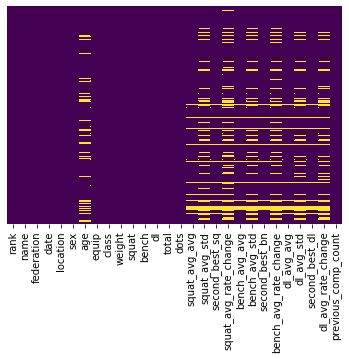

In [41]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
print('Number of null values in: ')
for col in df:
    print('- ' + col + ': ' + str(df.isnull()[col].sum()) + ', ' + str((df.isnull()[col].sum()/df.shape[0] * 100).round()) + '%')

From these null values, first I will drop the missing rows in squat, bench, and deadlift, since these are dependent variables whose values should be known to the model.

Next, I will impute the missing values in class with the correct values, as they can be determined through weight.

The rest of the columns are missing between 10% to 20%, a substantial fraction. For the columns created from the lifter's previous competition history, the null values are due to the lack of competitions. For this reason, these nulls are not missing at random, and dropping them would bias the dataset. Therefore, I will impute the nulls through MICE, which uses multiple regression models to take into account other variables.

### Drop null rows in dependent variables and calculate class from weight

In [42]:
# Drop null rows in squat, bench, deadlift
df = df[df['squat'].notna() & df['bench'].notna() & df['dl'].notna()]
df = df[df['squat_avg_std'].notna() & df['bench_avg_std'].notna() & df['dl_avg_std'].notna()]

# Calculate class from weight and sex
from bisect import bisect
def calculate_class(weight, sex):
    male_classes = [123, 132, 148, 165, 181, 198, 220, 242, 275, 308]
    female_classes = [97, 106, 115, 123, 132, 148, 165, 181, 198]
    classes = male_classes if sex == 'M' else female_classes
    result = classes[bisect(classes, weight) - 1]
    result = str(result) if bisect(classes, weight) == len(classes) else str(result) + '+'
    return result
df['class'][df['class'].isna()] = [calculate_class(weight, sex) if pd.isna(class_) else class_
                                   for weight, sex, class_ in zip(df['weight'][df['class'].isna()], 
                                                                  df['sex'][df['class'].isna()], 
                                                                  df['class'][df['class'].isna()])]

# Do the same for rows with '+' as class, which may be an error
df['class'][df['class'] == '+'] = [calculate_class(weight, sex) if class_ == '+' else class_
                                   for weight, sex, class_ in zip(df['weight'][df['class'] == '+'], 
                                                                  df['sex'][df['class'] == '+'], 
                                                                  df['class'][df['class'] == '+'])]
print(df.shape)

(7205, 28)


<ipython-input-42-5313bea4c59e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'][df['class'] == '+'] = [calculate_class(weight, sex) if class_ == '+' else class_


### Re-cast column types

In [43]:
# Fix age column values
df['age'][df['age'].notna()] = [age[:-1] if age[-1] == '~' else age for age in df['age'].dropna()]

# Recast column types
cols_to_float = ['rank','age','weight','squat','bench','dl','total','dots','squat_avg_avg','squat_avg_std',
                 'second_best_sq','squat_avg_rate_change','bench_avg_avg','bench_avg_std','second_best_bn',
                 'bench_avg_rate_change','dl_avg_avg','dl_avg_std','second_best_dl','dl_avg_rate_change',
                 'previous_comp_count']
df[cols_to_float] = df[cols_to_float].astype(float)

# Change class to string
df['class'] = df['class'].astype(str)

# Date to datetime object
df['date'] = pd.to_datetime(df['date'])

### Feature Engineering 
- New columns: month, season, year, country, state, number of bests in past year of same class, number of days since last best in same class
- Drop name column
- CatBoost Encode categorical variables

In [44]:
# Month, year
df['month'] = [date.month for date in df['date']]
df['year'] = [date.year for date in df['date']]

# Season
# Credit: https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime
from datetime import date
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
def get_season(now):
    now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= now <= end)
df['season'] = [get_season(date) for date in df['date']]

# Country, state
df['country'] = [loc.split('-')[0] for loc in df['location']]
df['state'] = [loc.split('-')[1] if len(loc.split('-')) > 1 else 'no state' for loc in df['location']]

# Number of bests in past year of same class (num_bests)
from dateutil.relativedelta import relativedelta
def get_num_bests(group): 
    group['one_year_ago'] = [dt - relativedelta(years=1) for dt in group['date']]
    num_bests = lambda today, one_year_ago: group[(group['date'] >= one_year_ago) & (group['date'] < today)].count()[0]
    zipper = lambda group: zip(group['date'], group['one_year_ago'])
    group['num_bests'] = [num_bests(today, one_year_ago) for today, one_year_ago in zipper(group)]
    group.drop(columns=['one_year_ago'], inplace=True)
    return group.sort_values(['date'])
df = df.groupby(['class']).apply(get_num_bests).reset_index(drop=True)

# Number of days since last best in same class (num_days)
df = df.groupby(['class']).apply(pd.DataFrame.sort_values, ['date']).reset_index(drop=True)
df['num_days'] = df.groupby(['class'])['date'].diff().dt.days

# Drop name col
df.drop(columns=['name'], inplace=True)

### CatBoost encode categorical variables

In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Apply the label encoder to categorical variables
cat_cols = ['federation','date','location','sex','equip','class','month','year','season','country','state']
df = df.join(df[cat_cols].apply(encoder.fit_transform).add_suffix('_enc'))
cat_cols_enc = list(map(lambda col: col + '_enc', cat_cols))

df = df.sort_values(['rank'])

# CatBoost encoding
import category_encoders as ce
target_enc_sq = ce.CatBoostEncoder(cols=cat_cols_enc)
target_enc_sq.fit(df[cat_cols_enc], df['squat'])

target_enc_bn = ce.CatBoostEncoder(cols=cat_cols_enc)
target_enc_bn.fit(df[cat_cols_enc], df['bench'])

target_enc_dl = ce.CatBoostEncoder(cols=cat_cols_enc)
target_enc_dl.fit(df[cat_cols_enc], df['dl'])

# Append catboost columns to df
df_sq = df.join(target_enc_sq.transform(df[cat_cols_enc]).add_suffix('_cb'))
df_bn = df.join(target_enc_bn.transform(df[cat_cols_enc]).add_suffix('_cb'))
df_dl = df.join(target_enc_dl.transform(df[cat_cols_enc]).add_suffix('_cb'))

### Impute the remaining nulls using MICE

In [46]:
from fancyimpute import IterativeImputer
mice_imputer = IterativeImputer()

# Create copies of dfs, dropping string columns and non-catboost encoded columns
mice_imputed_sq = df_sq.copy(deep=True).drop(columns=cat_cols + cat_cols_enc)
mice_imputed_bn = df_bn.copy(deep=True).drop(columns=cat_cols + cat_cols_enc)
mice_imputed_dl = df_dl.copy(deep=True).drop(columns=cat_cols + cat_cols_enc)
              
# Impute with MICE
mice_imputed_sq = pd.DataFrame(data=mice_imputer.fit_transform(mice_imputed_sq), columns=mice_imputed_sq.columns)
mice_imputed_bn = pd.DataFrame(data=mice_imputer.fit_transform(mice_imputed_bn), columns=mice_imputed_bn.columns)
mice_imputed_dl = pd.DataFrame(data=mice_imputer.fit_transform(mice_imputed_dl), columns=mice_imputed_dl.columns)

# Re-add non-numerically encoded columns
mice_imputed_sq = pd.concat([mice_imputed_sq, df_sq[cat_cols].reset_index(drop=True)], axis=1, sort=False)
mice_imputed_bn = pd.concat([mice_imputed_bn, df_bn[cat_cols].reset_index(drop=True)], axis=1, sort=False)
mice_imputed_dl = pd.concat([mice_imputed_dl, df_dl[cat_cols].reset_index(drop=True)], axis=1, sort=False)

display(mice_imputed_sq)
display(mice_imputed_bn)
display(mice_imputed_dl)
print(mice_imputed_sq.columns)

,rank,age,weight,squat,bench,dl,total,dots,squat_avg_avg,squat_avg_std,...,date,location,sex,equip,class,month,year,season,country,state
0,1.0,30.0,123.4,573.2,292.1,485.0,1350.3,709.96,457.863333,53.800172,...,2019-04-27,USA-CA,F,Wraps,123,4,2019,spring,USA,CA
1,2.0,24.0,177.2,639.3,374.8,595.2,1609.3,686.14,552.483333,50.014256,...,2019-08-03,USA-TX,F,Wraps,181,8,2019,summer,USA,TX
2,3.0,27.0,119.9,507.0,242.5,529.1,1278.6,685.45,382.126667,61.109527,...,2019-04-27,USA-CA,F,Wraps,123,4,2019,spring,USA,CA
3,4.0,27.0,147.6,565.0,320.0,550.0,1435.0,675.19,358.717778,102.088166,...,2019-03-02,USA-OH,F,Wraps,148,3,2019,winter,USA,OH
4,5.0,39.0,164.7,628.3,330.7,562.1,1521.2,673.47,480.487778,63.452406,...,2019-08-30,USA-CA,F,Wraps,165,8,2019,summer,USA,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7200,10952.0,27.0,218.7,595.2,380.3,628.3,1603.8,449.36,542.875000,19.480792,...,2018-05-11,England,M,Wraps,220,5,2018,spring,England,no state
7201,10953.0,26.0,168.9,507.0,292.1,600.7,1399.9,449.36,451.245455,23.109163,...,2018-12-08,Australia-ACT,M,Raw,169,12,2018,autumn,Australia,ACT
7202,10954.0,24.0,254.8,683.4,418.8,600.7,1703.0,449.35,534.854762,104.792800,...,2019-11-23,USA-UT,M,Wraps,275,11,2019,autumn,USA,UT
7203,10956.0,36.0,224.0,534.6,396.8,688.9,1620.4,449.34,546.550000,31.349883,...,2017-12-02,Russia,M,Raw,242,12,2017,autumn,Russia,no state


,rank,age,weight,squat,bench,dl,total,dots,squat_avg_avg,squat_avg_std,...,date,location,sex,equip,class,month,year,season,country,state
0,1.0,30.0,123.4,573.2,292.1,485.0,1350.3,709.96,457.863333,53.800172,...,2019-04-27,USA-CA,F,Wraps,123,4,2019,spring,USA,CA
1,2.0,24.0,177.2,639.3,374.8,595.2,1609.3,686.14,552.483333,50.014256,...,2019-08-03,USA-TX,F,Wraps,181,8,2019,summer,USA,TX
2,3.0,27.0,119.9,507.0,242.5,529.1,1278.6,685.45,382.126667,61.109527,...,2019-04-27,USA-CA,F,Wraps,123,4,2019,spring,USA,CA
3,4.0,27.0,147.6,565.0,320.0,550.0,1435.0,675.19,358.717778,102.088166,...,2019-03-02,USA-OH,F,Wraps,148,3,2019,winter,USA,OH
4,5.0,39.0,164.7,628.3,330.7,562.1,1521.2,673.47,480.487778,63.452406,...,2019-08-30,USA-CA,F,Wraps,165,8,2019,summer,USA,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7200,10952.0,27.0,218.7,595.2,380.3,628.3,1603.8,449.36,542.875000,19.480792,...,2018-05-11,England,M,Wraps,220,5,2018,spring,England,no state
7201,10953.0,26.0,168.9,507.0,292.1,600.7,1399.9,449.36,451.245455,23.109163,...,2018-12-08,Australia-ACT,M,Raw,169,12,2018,autumn,Australia,ACT
7202,10954.0,24.0,254.8,683.4,418.8,600.7,1703.0,449.35,534.854762,104.792800,...,2019-11-23,USA-UT,M,Wraps,275,11,2019,autumn,USA,UT
7203,10956.0,36.0,224.0,534.6,396.8,688.9,1620.4,449.34,546.550000,31.349883,...,2017-12-02,Russia,M,Raw,242,12,2017,autumn,Russia,no state


,rank,age,weight,squat,bench,dl,total,dots,squat_avg_avg,squat_avg_std,...,date,location,sex,equip,class,month,year,season,country,state
0,1.0,30.0,123.4,573.2,292.1,485.0,1350.3,709.96,457.863333,53.800172,...,2019-04-27,USA-CA,F,Wraps,123,4,2019,spring,USA,CA
1,2.0,24.0,177.2,639.3,374.8,595.2,1609.3,686.14,552.483333,50.014256,...,2019-08-03,USA-TX,F,Wraps,181,8,2019,summer,USA,TX
2,3.0,27.0,119.9,507.0,242.5,529.1,1278.6,685.45,382.126667,61.109527,...,2019-04-27,USA-CA,F,Wraps,123,4,2019,spring,USA,CA
3,4.0,27.0,147.6,565.0,320.0,550.0,1435.0,675.19,358.717778,102.088166,...,2019-03-02,USA-OH,F,Wraps,148,3,2019,winter,USA,OH
4,5.0,39.0,164.7,628.3,330.7,562.1,1521.2,673.47,480.487778,63.452406,...,2019-08-30,USA-CA,F,Wraps,165,8,2019,summer,USA,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7200,10952.0,27.0,218.7,595.2,380.3,628.3,1603.8,449.36,542.875000,19.480792,...,2018-05-11,England,M,Wraps,220,5,2018,spring,England,no state
7201,10953.0,26.0,168.9,507.0,292.1,600.7,1399.9,449.36,451.245455,23.109163,...,2018-12-08,Australia-ACT,M,Raw,169,12,2018,autumn,Australia,ACT
7202,10954.0,24.0,254.8,683.4,418.8,600.7,1703.0,449.35,534.854762,104.792800,...,2019-11-23,USA-UT,M,Wraps,275,11,2019,autumn,USA,UT
7203,10956.0,36.0,224.0,534.6,396.8,688.9,1620.4,449.34,546.550000,31.349883,...,2017-12-02,Russia,M,Raw,242,12,2017,autumn,Russia,no state


Index(['rank', 'age', 'weight', 'squat', 'bench', 'dl', 'total', 'dots',
       'squat_avg_avg', 'squat_avg_std', 'second_best_sq',
       'squat_avg_rate_change', 'bench_avg_avg', 'bench_avg_std',
       'second_best_bn', 'bench_avg_rate_change', 'dl_avg_avg', 'dl_avg_std',
       'second_best_dl', 'dl_avg_rate_change', 'previous_comp_count',
       'num_bests', 'num_days', 'federation_enc_cb', 'date_enc_cb',
       'location_enc_cb', 'sex_enc_cb', 'equip_enc_cb', 'class_enc_cb',
       'month_enc_cb', 'year_enc_cb', 'season_enc_cb', 'country_enc_cb',
       'state_enc_cb', 'federation', 'date', 'location', 'sex', 'equip',
       'class', 'month', 'year', 'season', 'country', 'state'],
      dtype='object')


### Download to CSV

In [47]:
path = '/Users/andrew/OneDrive - Williams College/Data Science Projects/Independent/powerlifting'
mice_imputed_sq.to_csv(path + '/mice_imputed_squat_data.csv', index=False)
mice_imputed_bn.to_csv(path + '/mice_imputed_bench_data.csv', index=False)
mice_imputed_dl.to_csv(path + '/mice_imputed_deadlift_data.csv', index=False)